<center><h2>Tweets Classification</h2></center>

<p>F  real time streaming tweets classification we need to train a model f  prediction.</p>

In [104]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, TextVectorization ,Embedding ,GlobalAveragePooling1D ,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


pd.options.display.max_colwidth = 300 
pass

In [105]:
data = pd.read_csv("data.csv")
data.head()

,post,usertag,time_date,label,__key__,__error__,__has_error__
0,NaN,NaN,NaN,NaN,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""startingdoc\"""",\n ""kind"": ""posts"",\n ""name"": ""startingdoc"",\n ""id"": null\n }\n}",[],False
1,https://foxnews.com/politics/doj-torched-prosecutors-announce-sam-bankman-fried-face-second-trial…\nThe Department of (In)Justice doing its job protecting the #NaziDemocrats by keeping their treasonous crimes covered up. #NaziScums #ResistingDemocratFascism #DemocratsTheNewNazis #IStandWithIsrae...,@Big0range31,2023-12-30 22:55:29,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5SltHdL2FYtDuVweFRXg\"""",\n ""kind"": ""posts"",\n ""name"": ""5SltHdL2FYtDuVweFRXg"",\n ""id"": null\n }\n}",[],False
2,#IStandWithIsrael “thousands at event calling for the country's resettlement of Gaza - NBC News,@LorraineMayLevy,2024-01-29 13:45:32,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5EGsMYmUyHTQeVd27d2c\"""",\n ""kind"": ""posts"",\n ""name"": ""5EGsMYmUyHTQeVd27d2c"",\n ""id"": null\n }\n}",[],False
3,"#istandwithisrael and not #istandwithjews means you stand for this : Israel is a militarised ethno state. \n\nStand with the Jewish people, not the barbarians responsible for this, the IDF *is* The state of Israel.",@SapphosShahuda,2023-11-29 00:21:06,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5EdJPNUV8Mw4xprgaOCu\"""",\n ""kind"": ""posts"",\n ""name"": ""5EdJPNUV8Mw4xprgaOCu"",\n ""id"": null\n }\n}",[],False
4,"The images of Hamas' brutality are gruesome — reminiscent of the worst of Al-Qaeda, ISIS and the Taliban.\n\nUrge America's leaders to #StandWithIsrael as it defeats this terrorist threat:",@Deborah83556516,2024-01-26 02:35:05,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5H9s7aG3b8v8wunxXV3B\"""",\n ""kind"": ""posts"",\n ""name"": ""5H9s7aG3b8v8wunxXV3B"",\n ""id"": null\n }\n}",[],False


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13163 entries, 0 to 13162
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   post           13162 non-null  object
 1   usertag        13162 non-null  object
 2   time_date      13162 non-null  object
 3   label          13162 non-null  object
 4   __key__        13163 non-null  object
 5   __error__      13163 non-null  object
 6   __has_error__  13163 non-null  bool  
dtypes: bool(1), object(6)
memory usage: 630.0+ KB


<p>the first row is the only row with missing values, let's remove it.</p>

In [107]:
data = data.tail(len(data) - 1)

In [108]:
data.columns = ["text","usertag","date","label","__key__","__err __","__has_err __"]
data = data.astype(str)
data["target"] = data["label"].apply(lambda x: 0 if x == "P" else 1)

<p>No err  in the dataset</p>

In [109]:
data["__has_err __"].unique()

array(['False'], dtype=object)

<p>we will drop __key__, __err __ and __has__err __ columns. The key column uniquely identifies all rows even the one with duplicate tweets. </p>

In [110]:
data.drop(["__key__","__err __","__has_err __"],axis=1,inplace=True)

In [111]:
data.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Index: 11951 entries, 1 to 13162
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     11951 non-null  object
 1   usertag  11951 non-null  object
 2   date     11951 non-null  object
 3   label    11951 non-null  object
 4   target   11951 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 560.2+ KB


<center><h2>Text processing</h2></center>

<p>For the labeling of data, it was done on the hypothesis that tweets containing hashtags in supp t of israel would be deemed as pro israel, and tweets containing hashtags in supp t of palestine would be deemed as pro palestine.</p>
<ul>
<li>
Pro Palestine tags : #freepalestine
#supportpalestine
#standwithpalestine
#istandwithpalestine
#westandwithpalestine</li>
<li>
Pro Israel tags :  #freeisrael
#supportisrael
#standwithisrael
#istandwithisrael
#westandwithisrael</li>
</ul>
<p>Out of fear that these tags will bias the model too much, we should have two datasets for the models to train on, one with these tags and one without.</p>

In [117]:
search_tags = ["#freepalestine","#supportpalestine","#standwithpalestine","#istandwithpalestine","#westandwithpalestine",
               "#freeisrael","#supportisrael","#standwithisrael","#istandwithisrael","#westandwithisrael"]
data2 = data.copy()
data2["text"] = data["text"].apply(lambda x: ' '.join(word for word in x.split() if word.lower() not in search_tags))

In [114]:
data["text"].head(5)

1    https://foxnews.com/politics/doj-torched-prosecutors-announce-sam-bankman-fried-face-second-trial…\nThe Department of (In)Justice doing its job protecting the #NaziDemocrats by keeping their treasonous crimes covered up. #NaziScums #ResistingDemocratFascism #DemocratsTheNewNazis #IStandWithIsrae...
2                                                                                                                                                                                                                #IStandWithIsrael “thousands at event calling for the country's resettlement of Gaza - NBC News
3                                                                                         #istandwithisrael and not #istandwithjews means you stand for this : Israel is a militarised ethno state. \n\nStand with the Jewish people, not the barbarians responsible for this, the IDF *is* The state of Israel.
4                                                                                    

word cloud for data with search tags

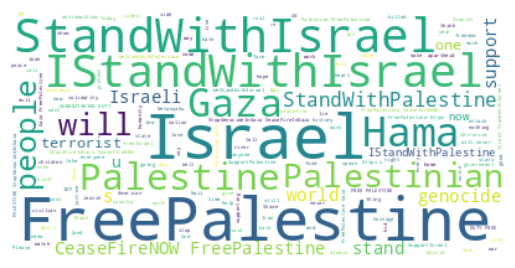

In [115]:
text = " ".join(review for  review in data["text"])
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

word cloud for data without search tags

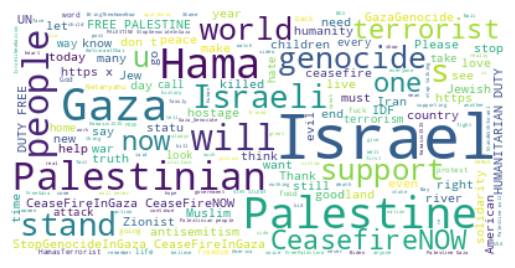

In [118]:
text = " ".join(review for  review in data2["text"])
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

I will merge the two datasets into one

In [120]:
data = pd.concat([data,data2])

here is the new word cloud , hopefully this will stop the model from relying too much on the search tags so it can be more reliable for other types of data. 

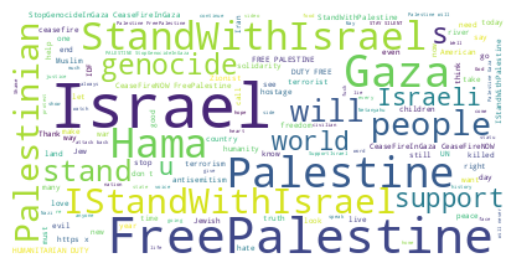

In [121]:
text = " ".join(review for  review in data["text"])
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Removing URLs, Mentions, Emojis

In [122]:
import preprocessor  as p
p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.RESERVED,p.OPT.EMOJI,p.OPT.SMILEY,p.OPT.NUMBER)
data["text"] = data["text"].apply(lambda x : p.clean(x))

In [123]:
data["text"]

1                                    The Department of (In)Justice doing its job protecting the #NaziDemocrats by keeping their treasonous crimes covered up. #NaziScums #ResistingDemocratFascism #DemocratsTheNewNazis #IStandWithIsrael #SupportIsrael
2                                                                                                                                                          #IStandWithIsrael thousands at event calling for the country's resettlement of Gaza - NBC News
3                                      #istandwithisrael and not #istandwithjews means you stand for this : Israel is a militarised ethno state. Stand with the Jewish people, not the barbarians responsible for this, the IDF *is* The state of Israel.
4                                                                 The images of Hamas' brutality are gruesome reminiscent of the worst of Al-Qaeda, ISIS and the Taliban. Urge America's leaders to #StandWithIsrael as it defeats this terrorist threat:


#### Expanding contractions

In [124]:
import re
contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not"}
# Regular expression f  finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the reviews
data['text']=data['text'].apply(lambda x:expand_contractions(str(x)))

#### Lower case

In [125]:
data["text"] = data["text"].str.lower()

#### Removing punctuation

In [126]:
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [127]:
data['text'] = data['text'].apply(lambda x: re.sub(f'[{re.escape(punctuation)}]', '' , str(x)))

#### Stop words

In [128]:
from wordcloud import STOPWORDS

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in STOPWORDS]))

#### Lemmatization 

In [129]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('w dnet')

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
data["text"] = data["text"].apply(lambda text: lemmatize_words(text))

[nltk_data] Error loading w dnet: Package 'w dnet' not found in index


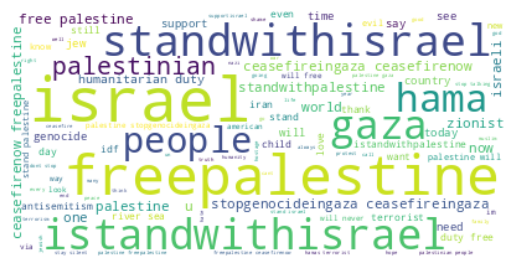

In [130]:
text = " ".join(review for  review in data["text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color ="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

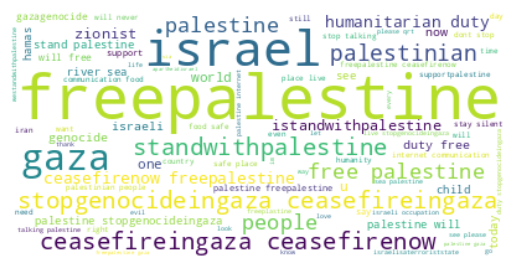

In [131]:
text = " ".join(review for review in data.loc[data["label"] == "P"]["text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color ="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

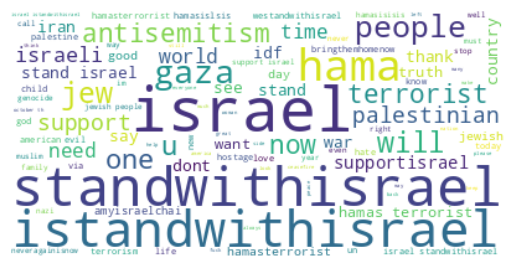

In [132]:
text = " ".join(review for review in data.loc[data["label"] == "I"]["text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color ="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [133]:
data.head(10)["text"]

1                                       department injustice job protecting nazidemocrats keeping treasonous crime covered naziscums resistingdemocratfascism democratsthenewnazis istandwithisrael supportisrael
2                                                                                                                                      istandwithisrael thousand event calling country resettlement gaza nbc news
3                                                                            istandwithisrael istandwithjews mean stand israel militarised ethno state stand jewish people barbarian responsible idf state israel
4                                                                                image hamas brutality gruesome reminiscent worst alqaeda isi taliban urge america leader standwithisrael defeat terrorist threat
5                                                                                                                           well worth read excellent historical

#### handling data imbalance

<p>There is a bias in the data, we need to make sure there are as many posts in fav  of palestine as there are in fav  of israel.</p>

<Axes: xlabel='label', ylabel='count'>

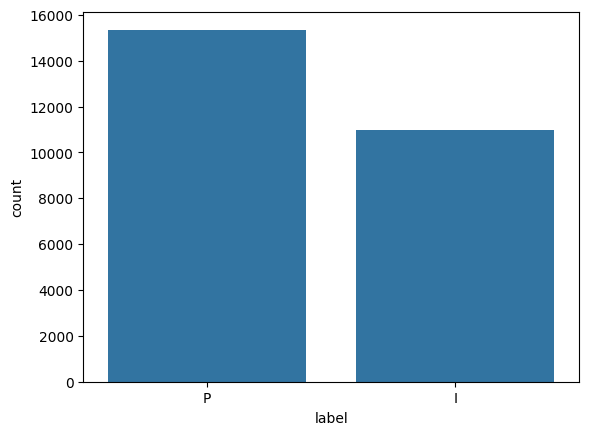

In [134]:
sns.barplot(data["label"].value_counts())

<Axes: xlabel='label', ylabel='count'>

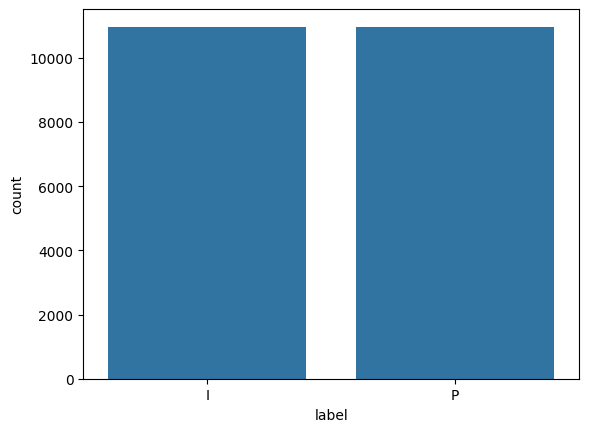

In [135]:
g = data.groupby("label")
data_balanced = g.head(min(data["label"].value_counts()))
sns.barplot(data_balanced["label"].value_counts())


<center><h2>Model training</h2></center>

#### Train test Split

In [136]:
x_train, x_test, y_train, y_test = train_test_split(data_balanced["text"],data_balanced["target"], test_size=0.2,random_state=42)

#### Tokenization

In [137]:

MAX_SEQUENCE_LENGTH = 280
VOCAB_SIZE = 10000
int_vectorize_layer =  TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)


In [138]:
int_vectorize_layer.adapt(x_train)

In [139]:
x_train_tokenized = int_vectorize_layer(x_train)
x_test_tokenized = int_vectorize_layer(x_test)

In [140]:
print('Shape of training tensor: ', x_train_tokenized.shape)
print('Shape of testing tensor: ', x_test_tokenized.shape)

Shape of training tensor:  (17548, 280)
Shape of testing tensor:  (4388, 280)


#### Dense Model

In [141]:
# Define parameter
vocab_size = 500 
embedding_dim = 16
drop_value = 0.2
n_dense = 24# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = MAX_SEQUENCE_LENGTH))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [142]:
num_epochs = 20
history = model.fit(x_train_tokenized,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(x_test_tokenized, y_test),
                     verbose=2)

Epoch 1/20
549/549 - 2s - 4ms/step - accuracy: 0.5266 - loss: 0.6910 - val_accuracy: 0.6290 - val_loss: 0.6806
Epoch 2/20
549/549 - 1s - 2ms/step - accuracy: 0.6617 - loss: 0.6335 - val_accuracy: 0.5670 - val_loss: 0.6108
Epoch 3/20
549/549 - 1s - 2ms/step - accuracy: 0.8076 - loss: 0.4446 - val_accuracy: 0.8393 - val_loss: 0.3578
Epoch 4/20
549/549 - 1s - 2ms/step - accuracy: 0.8742 - loss: 0.3023 - val_accuracy: 0.8906 - val_loss: 0.2586
Epoch 5/20
549/549 - 1s - 2ms/step - accuracy: 0.8932 - loss: 0.2533 - val_accuracy: 0.8421 - val_loss: 0.3039
Epoch 6/20
549/549 - 1s - 2ms/step - accuracy: 0.9021 - loss: 0.2339 - val_accuracy: 0.9132 - val_loss: 0.1970
Epoch 7/20
549/549 - 1s - 2ms/step - accuracy: 0.9076 - loss: 0.2146 - val_accuracy: 0.8380 - val_loss: 0.3215
Epoch 8/20
549/549 - 1s - 2ms/step - accuracy: 0.9057 - loss: 0.2175 - val_accuracy: 0.8906 - val_loss: 0.2581
Epoch 9/20
549/549 - 1s - 2ms/step - accuracy: 0.9087 - loss: 0.2127 - val_accuracy: 0.9248 - val_loss: 0.1756
E

In [143]:
model.evaluate(x_test_tokenized,y_test)

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.9217 - loss: 0.1707


[0.16482359170913696, 0.9236554503440857]